# Asteroid Threat Prediction Analysis

## Research Questions

* How accurately can we predict threat category before the close-approach event using only pre-event information?
* Which features most strongly drive predicted risk?
* Do non-linear models (e.g., tree ensembles or GAMs) materially outperform regularized linear baselines under time-aware testing?


## Imports


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, SplineTransformer, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    f1_score, accuracy_score, average_precision_score,
    ConfusionMatrixDisplay
)
from sklearn.calibration import calibration_curve
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


## Data Loading


In [2]:
df = pd.read_csv('asteriod.csv')
df.head()


,asteroid_designation,asteroid_fullname,close_approach_date,year,month,distance_au,velocity_km_s,absolute_magnitude,days_until_approach,is_past_event,is_future_event,risk_score,panic_level,threat_category,panic_verdict,on_sentry_list,sentry_impact_prob,sentry_torino_scale,sentry_palermo_scale,sentry_diameter_km
0,2020 AY1,(2020 AY1),2020-01-01 00:54:00,2020,1,0.021164,5.621422,25.3,-2119,True,False,0.384272,4,MONITOR,"Worth a tweet, not worth a bunker.",False,NaN,NaN,NaN,NaN
1,2019 YK,(2019 YK),2020-01-01 02:06:00,2020,1,0.036101,7.359263,24.1,-2119,True,False,0.362620,4,MONITOR,"Worth a tweet, not worth a bunker.",False,NaN,NaN,NaN,NaN
2,2013 EC20,(2013 EC20),2020-01-01 03:23:00,2020,1,0.162019,2.793701,29.0,-2119,True,False,0.189181,2,SAFE,You're fine. Go touch grass.,True,4.723700e-07,0.0,-8.94,0.0054
3,2020 AM1,(2020 AM1),2020-01-01 07:18:00,2020,1,0.159657,4.152938,24.7,-2119,True,False,0.100336,1,SAFE,You're fine. Go touch grass.,False,NaN,NaN,NaN,NaN
4,2020 AP3,(2020 AP3),2020-01-01 11:13:00,2020,1,0.016740,5.191250,26.6,-2118,True,False,0.391083,4,MONITOR,"Worth a tweet, not worth a bunker.",False,NaN,NaN,NaN,NaN


## Data Cleaning


In [3]:
if "close_approach_date" in df.columns:
    df["close_approach_date"] = pd.to_datetime(df["close_approach_date"], errors="coerce")
    df["year"] = df["close_approach_date"].dt.year

if "days_until_approach" in df.columns:
    df["days_until_approach"] = pd.to_numeric(df["days_until_approach"], errors="coerce")
    df["is_past_event"] = df["days_until_approach"] < 0
    df["abs_days_to_approach"] = df["days_until_approach"].abs()

if "on_sentry_list" in df.columns:
    if df["on_sentry_list"].dtype == "O":
        df["on_sentry_list"] = (
            df["on_sentry_list"]
            .astype(str).str.strip().str.lower()
            .map({"true": True, "false": False, "1": True, "0": False})
        )
    try:
        df["on_sentry_list"] = df["on_sentry_list"].astype("boolean")
    except Exception:
        pass

for col in ["threat_category", "panic_verdict", "panic_level"]:
    if col in df.columns:
        df[col] = df[col].astype("category")

for col in ["velocity_km_s", "distance_au", "absolute_magnitude", "risk_score"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

low_missing_numeric = []
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        miss = df[col].isna().mean()
        if 0 < miss < 0.05:
            low_missing_numeric.append(col)

for col in low_missing_numeric:
    df[col] = df[col].fillna(df[col].median())

sparse_cols = [c for c in df.columns if df[c].isna().mean() >= 0.90]
if sparse_cols:
    df.drop(columns=sparse_cols, inplace=True)

print("Clean shape:", df.shape)
print("Top NA counts:")
print(df.isna().sum().sort_values(ascending=False).head(15))
print("\nDtypes:")
print(df.dtypes.head(20))


Clean shape: (89227, 17)
Top NA counts:
asteroid_designation    0
is_past_event           0
on_sentry_list          0
panic_verdict           0
threat_category         0
panic_level             0
risk_score              0
is_future_event         0
days_until_approach     0
asteroid_fullname       0
absolute_magnitude      0
velocity_km_s           0
distance_au             0
month                   0
year                    0
dtype: int64

Dtypes:
asteroid_designation            object
asteroid_fullname               object
close_approach_date     datetime64[ns]
year                             int32
month                            int64
distance_au                    float64
velocity_km_s                  float64
absolute_magnitude             float64
days_until_approach              int64
is_past_event                     bool
is_future_event                   bool
risk_score                     float64
panic_level                   category
threat_category               category
pa

## Configuration


In [4]:
SPLIT_YEAR = 2090
N_SPLITS = 5
LEAK_FEATURES = {"risk_score", "panic_level", "panic_verdict"}
CLASS_TARGET = "threat_category"
REG_TARGET = "risk_score"
ALWAYS_EXCLUDE = {CLASS_TARGET, REG_TARGET, "close_approach_date"}


## Train-Test Split


In [5]:
def time_split(df, year_col="year", split_year=SPLIT_YEAR):
    train = df[df[year_col] <= split_year].copy()
    test = df[df[year_col] > split_year].copy()
    return train, test

train_df, test_df = time_split(df, "year", SPLIT_YEAR)
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")


Train size: 81458, Test size: 7769


## Preprocessing Setup


In [6]:
def get_preprocessor(df):
    numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
    categorical_cols = df.select_dtypes(include=["object", "category", "boolean"]).columns.tolist()
    
    drop_cols = LEAK_FEATURES | ALWAYS_EXCLUDE
    numeric_cols = [c for c in numeric_cols if c not in drop_cols]
    categorical_cols = [c for c in categorical_cols if c not in drop_cols]
    
    preproc = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ]
    )
    return preproc, numeric_cols, categorical_cols

preproc, numeric_cols, categorical_cols = get_preprocessor(train_df)
print(f"Numeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")


Numeric columns: 7
Categorical columns: 5


## Feature Engineering


In [7]:
SAFE_FEATURES = [c for c in df.columns if c not in (LEAK_FEATURES | ALWAYS_EXCLUDE)]

def build_Xy(df, target, drop_leak=True):
    cols = SAFE_FEATURES + [target]
    cols = [c for c in cols if c in df.columns]
    
    X = df[cols].copy()
    y = X.pop(target)
    
    if drop_leak:
        for leak in LEAK_FEATURES:
            if leak in X.columns:
                X.drop(columns=leak, inplace=True)
    
    return X, y

X_train_clf, y_train_clf = build_Xy(train_df, CLASS_TARGET, drop_leak=True)
X_test_clf, y_test_clf = build_Xy(test_df, CLASS_TARGET, drop_leak=True)

X_train_reg, y_train_reg = build_Xy(train_df, REG_TARGET, drop_leak=False)
X_test_reg, y_test_reg = build_Xy(test_df, REG_TARGET, drop_leak=False)


## Cross-Validation Setup


In [8]:
def blocked_cv(train_df, group_col="year", n_splits=5):
    groups = train_df[group_col].values
    gkf = GroupKFold(n_splits=n_splits)
    return gkf, groups

gkf, groups_train = blocked_cv(train_df, "year", N_SPLITS)


## Baseline Models

### Regression Baseline


Regression Baseline: LinearRegression
MAE: 1.770869e-06
RMSE: 3.154386e-06
R²: 1.000000


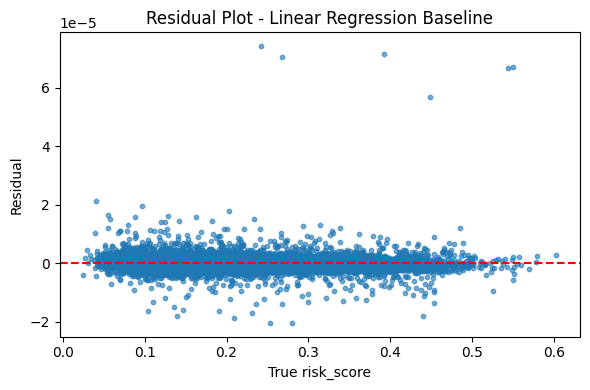

In [9]:
reg_baseline = Pipeline([
    ("preproc", preproc),
    ("model", LinearRegression())
])

reg_baseline.fit(X_train_reg, y_train_reg)
y_pred_reg = reg_baseline.predict(X_test_reg)

mae = mean_absolute_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)

print("Regression Baseline: LinearRegression")
print(f"MAE: {mae:.6e}")
print(f"RMSE: {rmse:.6e}")
print(f"R²: {r2:.6f}")

residuals = y_test_reg - y_pred_reg
plt.figure(figsize=(6, 4))
plt.scatter(y_test_reg, residuals, s=10, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("True risk_score")
plt.ylabel("Residual")
plt.title("Residual Plot - Linear Regression Baseline")
plt.tight_layout()
plt.show()


### Classification Baseline


Classification Baseline: Logistic Regression
F1-macro: 0.9765
Accuracy: 0.9879
PR-AUC (macro): 0.7493
Brier score: 0.006272


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


<Figure size 600x500 with 0 Axes>

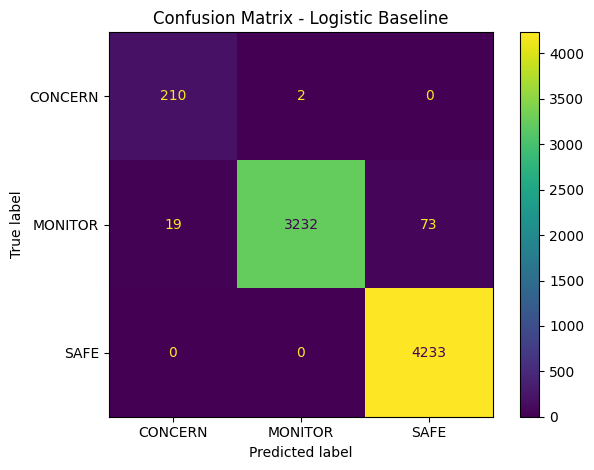

In [10]:
def pr_auc_macro_from_proba(y_true, y_proba, classes):
    y_true = np.asarray(y_true)
    y_bin = label_binarize(y_true, classes=classes)
    scores = []
    for i in range(len(classes)):
        scores.append(average_precision_score(y_bin[:, i], y_proba[:, i]))
    return float(np.mean(scores))

clf_baseline = Pipeline([
    ("preproc", preproc),
    ("model", LogisticRegression(
        solver="lbfgs",
        max_iter=5000,
        class_weight="balanced",
        random_state=42
    ))
])

clf_baseline.fit(X_train_clf, y_train_clf)
y_pred_clf = clf_baseline.predict(X_test_clf)
y_proba_clf = clf_baseline.predict_proba(X_test_clf)

f1_macro = f1_score(y_test_clf, y_pred_clf, average="macro")
acc = accuracy_score(y_test_clf, y_pred_clf)
classes = clf_baseline.named_steps["model"].classes_
pr_auc_macro = pr_auc_macro_from_proba(y_test_clf, y_proba_clf, classes)

y_test_bin = label_binarize(y_test_clf, classes=classes)
brier = np.mean((y_test_bin - y_proba_clf)**2)

print("Classification Baseline: Logistic Regression")
print(f"F1-macro: {f1_macro:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"PR-AUC (macro): {pr_auc_macro:.4f}")
print(f"Brier score: {brier:.6f}")

plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test_clf, y_pred_clf)
plt.title("Confusion Matrix - Logistic Baseline")
plt.tight_layout()
plt.show()


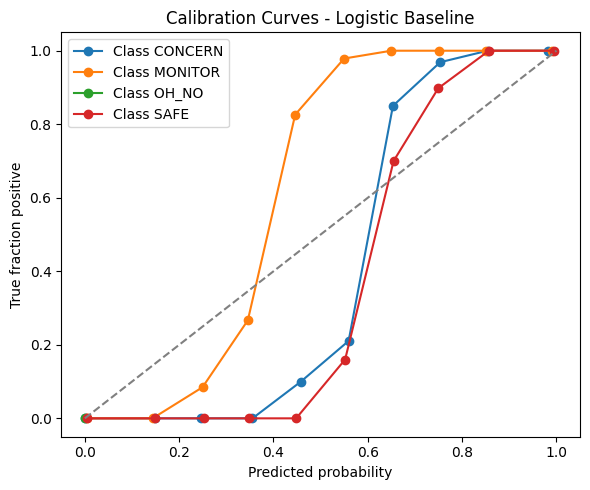

In [11]:
plt.figure(figsize=(6, 5))
for i, cls in enumerate(classes):
    y_true_bin = (y_test_clf == cls).astype(int)
    prob_pos = y_proba_clf[:, i]
    frac_pos, mean_pred = calibration_curve(y_true_bin, prob_pos, n_bins=10)
    plt.plot(mean_pred, frac_pos, marker='o', label=f"Class {cls}")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Predicted probability")
plt.ylabel("True fraction positive")
plt.title("Calibration Curves - Logistic Baseline")
plt.legend()
plt.tight_layout()
plt.show()


## Regularized Models

### Ridge Regression


In [12]:
gkf_fast = GroupKFold(n_splits=3)
reg_searches = {}

ridge_pipe = Pipeline([
    ("preproc", preproc),
    ("model", Ridge(random_state=42))
])

ridge_grid = {"model__alpha": [0.1, 1.0, 10.0]}

ridge_cv = GridSearchCV(
    ridge_pipe,
    param_grid=ridge_grid,
    cv=gkf_fast,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

ridge_cv.fit(X_train_reg, y_train_reg, groups=groups_train)
reg_searches["Ridge"] = ridge_cv
print(f"Best alpha: {ridge_cv.best_params_['model__alpha']}")
print(f"CV score: {ridge_cv.best_score_:.6e}")


Best alpha: 0.1
CV score: -4.734907e-05


### Lasso Regression


In [13]:
lasso_pipe = Pipeline([
    ("preproc", preproc),
    ("model", Lasso(random_state=42, max_iter=2000))
])

lasso_grid = {"model__alpha": [0.001, 0.01]}

lasso_cv = GridSearchCV(
    lasso_pipe,
    param_grid=lasso_grid,
    cv=gkf_fast,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

lasso_cv.fit(X_train_reg, y_train_reg, groups=groups_train)
reg_searches["Lasso"] = lasso_cv
print(f"Best alpha: {lasso_cv.best_params_['model__alpha']}")
print(f"CV score: {lasso_cv.best_score_:.6e}")


Best alpha: 0.001
CV score: -5.112310e-03


## Unsupervised Analysis

### PCA


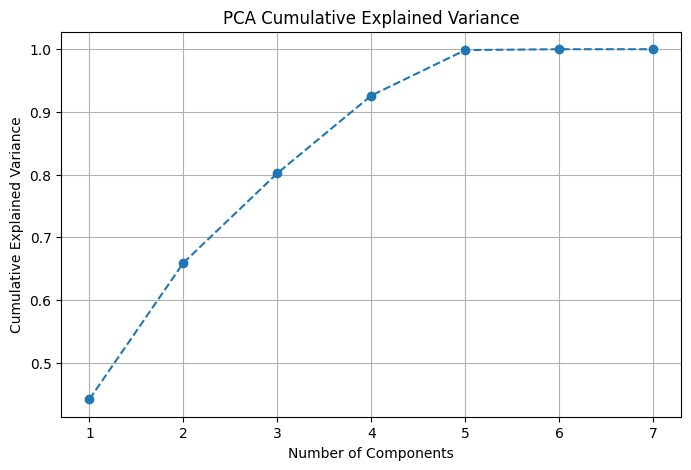

In [14]:
X_num = X_train_clf.select_dtypes(include=np.number)
scaler_unsup = StandardScaler()
X_scaled = scaler_unsup.fit_transform(X_num)

pca = PCA()
pca.fit(X_scaled)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')
plt.grid(True)
plt.show()


### KMeans Clustering


In [15]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init="auto")
kmeans.fit(X_scaled)
labels = kmeans.labels_

X_num_clustered = X_num.copy()
X_num_clustered['cluster'] = labels
cluster_summary = X_num_clustered.groupby('cluster').mean()

print("Cluster Summary (Mean values per cluster):")
display(cluster_summary)

print("\nCrosstab (Cluster vs Threat Category):")
crosstab_res = pd.crosstab(pd.Series(labels, name="Cluster"), y_train_clf.reset_index(drop=True))
display(crosstab_res)


Cluster Summary (Mean values per cluster):


,year,month,distance_au,velocity_km_s,absolute_magnitude,days_until_approach,abs_days_to_approach
cluster,,,,,,,
0,2041.282058,6.377081,0.131275,19.142235,20.660805,5832.838561,6206.692346
1,2071.692506,9.717593,0.113550,10.345142,24.011862,17042.279505,17042.279505
2,2026.999138,6.694074,0.041975,9.560483,25.909445,625.845237,2062.718660
3,2071.585338,3.387338,0.112240,10.445593,24.036565,16809.902433,16809.902433
4,2032.596730,6.701895,0.148647,9.044048,24.863055,2670.461718,3379.317571



Crosstab (Cluster vs Threat Category):


threat_category,CONCERN,MONITOR,OH_NO,SAFE
Cluster,,,,
0,4517,6188,12,1238
1,3199,8210,0,4097
2,8014,11102,184,427
3,3323,7987,0,3695
4,3810,9188,0,6267


## Non-Linear Models

### Polynomial Regression


In [16]:
poly_preproc = ColumnTransformer([
    ("num_poly", Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=2, include_bias=False))
    ]), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

poly_reg_pipe = Pipeline([
    ("preproc", poly_preproc),
    ("model", LinearRegression())
])

poly_reg_pipe.fit(X_train_reg, y_train_reg)
y_pred_poly = poly_reg_pipe.predict(X_test_reg)

mae_poly = mean_absolute_error(y_test_reg, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test_reg, y_pred_poly))
r2_poly = r2_score(y_test_reg, y_pred_poly)

print("Polynomial Regression (Degree 2)")
print(f"MAE: {mae_poly:.6e}")
print(f"RMSE: {rmse_poly:.6e}")
print(f"R²: {r2_poly:.6f}")


Polynomial Regression (Degree 2)
MAE: 4.222084e-06
RMSE: 6.176888e-06
R²: 1.000000


### Spline Regression


In [17]:
spline_preproc = ColumnTransformer([
    ("num_spline", Pipeline([
        ("scaler", StandardScaler()),
        ("spline", SplineTransformer(n_knots=4, degree=3, include_bias=False))
    ]), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

spline_reg_pipe = Pipeline([
    ("preproc", spline_preproc),
    ("model", LinearRegression())
])

spline_reg_pipe.fit(X_train_reg, y_train_reg)
y_pred_spline = spline_reg_pipe.predict(X_test_reg)

mae_spline = mean_absolute_error(y_test_reg, y_pred_spline)
rmse_spline = np.sqrt(mean_squared_error(y_test_reg, y_pred_spline))
r2_spline = r2_score(y_test_reg, y_pred_spline)

print("Spline Regression")
print(f"MAE: {mae_spline:.6f}")
print(f"RMSE: {rmse_spline:.6f}")
print(f"R²: {r2_spline:.6f}")


Spline Regression
MAE: 0.020054
RMSE: 0.023099
R²: 0.955698


## Final Evaluation & Leaderboard


Final Regression Leaderboard (Test Set):


,Model,MAE,RMSE,R2
0,Linear Baseline,0.000002,0.000003,1.000000
3,Polynomial (Deg 2),0.000004,0.000006,1.000000
1,Ridge,0.000030,0.000039,1.000000
2,Lasso,0.006872,0.007203,0.995692
4,Spline (Deg 3),0.020054,0.023099,0.955698


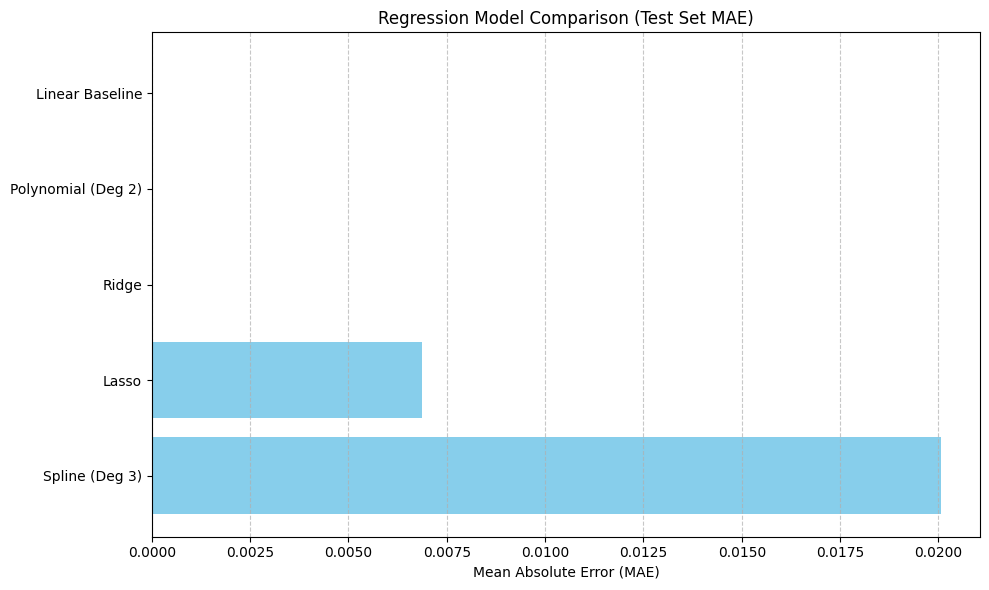

In [ ]:
best_ridge = reg_searches["Ridge"].best_estimator_
best_lasso = reg_searches["Lasso"].best_estimator_

y_pred_ridge = best_ridge.predict(X_test_reg)
mae_ridge = mean_absolute_error(y_test_reg, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test_reg, y_pred_ridge))
r2_ridge = r2_score(y_test_reg, y_pred_ridge)

y_pred_lasso = best_lasso.predict(X_test_reg)
mae_lasso = mean_absolute_error(y_test_reg, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test_reg, y_pred_lasso))
r2_lasso = r2_score(y_test_reg, y_pred_lasso)

leaderboard_data = [
    {"Model": "Linear Baseline", "MAE": mae, "RMSE": rmse, "R2": r2},
    {"Model": "Ridge", "MAE": mae_ridge, "RMSE": rmse_ridge, "R2": r2_ridge},
    {"Model": "Lasso", "MAE": mae_lasso, "RMSE": rmse_lasso, "R2": r2_lasso},
    {"Model": "Polynomial (Deg 2)", "MAE": mae_poly, "RMSE": rmse_poly, "R2": r2_poly},
    {"Model": "Spline (Deg 3)", "MAE": mae_spline, "RMSE": rmse_spline, "R2": r2_spline}
]

final_reg_leaderboard = pd.DataFrame(leaderboard_data)
final_reg_leaderboard.sort_values("MAE", ascending=True, inplace=True)

print("Final Regression Leaderboard (Test Set):")
display(final_reg_leaderboard)

plt.figure(figsize=(10, 6))
plt.barh(final_reg_leaderboard["Model"], final_reg_leaderboard["MAE"], color='skyblue')
plt.xlabel("Mean Absolute Error (MAE)")
plt.title("Regression Model Comparison (Test Set MAE)")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

